<a href="https://colab.research.google.com/github/NHCh1/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [66]:
import numpy as np
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV, mutual_info_classif
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import time
import os

# Data Loading

In [2]:
url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Dli-mendeley_18.csv'
data = pd.read_csv(url, header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1,1,50,0,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,2,1,4,59,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,2,1,4,57,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,3,1,1,49,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


# Pre-processing

In [3]:
#Array of features
x = data.drop([48], axis=1)
print(x)

#Array of target
y = data[48]
print(y)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

In [4]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [5]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print('------------------------------------------------------------------')
print(x_test)

[[ 0.4264587  -0.76932106 -0.15488093 ...  0.39933321 -0.23638944
   0.76186885]
 [-1.06951269 -0.76932106 -0.69750681 ...  0.39933321  1.0884513
   0.76186885]
 [ 1.92243009  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
  -1.47048024]
 [-0.32152699  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  0.38774495 ...  0.39933321  1.0884513
   0.76186885]]
------------------------------------------------------------------
[[-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
   0.76186885]
 [ 9.40228702  0.5460789   0.38774495 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  2.0156226  ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [ 0.4264587   0.5460789  -1.2401327  ... -1.51922032 -1.56123018
  -0.35430569]
 [-1.06951269 -0.76932106 -1.78275858 ...  0.39933321 -0.23638944
  -0.35430569]
 [-0.32152699  0.5460789  -0.154880

# Model Training

## XGBoost

Defining XGBoost Model

In [6]:
xgb_basic = XGBClassifier(eval_metric='error',
                          use_label_encoder=False,
                          n_jobs=-1,
                          random_state=42,
                          verbosity=0
                          )

Performing feature selection in XGBoost

In [7]:
selector = RFECV(xgb_basic, cv=5, n_jobs=-1)
selector.fit(x, y)

selected_cols = np.where(selector.ranking_ == 1)[0]
print(f"Selected feature indices: {selected_cols}")

xgb_pipe = make_pipeline(ColumnSelector(cols=selected_cols),
                         XGBClassifier(eval_metric='error',
                                       use_label_encoder=False,
                                       n_jobs=-1,
                                       random_state=42
                                       )
                         )

xgb_pipe.fit(x_train, y_train)
xgb_pipe_train = xgb_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_pipe_test = xgb_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
xgb_pipe_accuracy = xgb_pipe.score(x_test, y_test)
print(f"Accuracy: {xgb_pipe_accuracy:.8f}")

Selected feature indices: [ 0  1  2  3  4  5  8  9 10 11 13 14 15 18 20 21 22 24 25 26 27 28 29 30
 31 32 33 34 38 39 40 41 45 46 47]
Accuracy: 0.98433333


Finding best hyperparameters and best threshold in XGBoost

In [8]:
param_dist = {'xgbclassifier__max_depth': [4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
              'xgbclassifier__n_estimators': [1000, 2000, 3000],
              'xgbclassifier__subsample': [0.7, 0.8, 0.9],
              'xgbclassifier__colsample_bytree': [0.7, 0.8, 0.9],
              'xgbclassifier__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]
              }

xgb_search = RandomizedSearchCV(xgb_pipe,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=5,
                                n_jobs=-1,
                                scoring='accuracy',
                                verbose=1
                                )

xgb_search.fit(x_train, y_train)
print("Best Hyperparameters:", xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]
xgb_model_train = xgb_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_model_test = xgb_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

thresholds = [i / 100 for i in range(1, 100)]
best_acc, best_thresh = 0, 0

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"Best Threshold: {best_thresh:.4f}, Best Accuracy: {best_acc:.8f}")
xgb_final_pred = (xgb_probs >= best_thresh).astype(int)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'xgbclassifier__subsample': 0.9, 'xgbclassifier__scale_pos_weight': 1.006305531670966, 'xgbclassifier__n_estimators': 2000, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.9}
Best Threshold: 0.5000, Best Accuracy: 0.98533333


XGBoost Model Training Result

In [9]:
xgb_acc     = accuracy_score(y_test, xgb_final_pred)
xgb_prec    = precision_score(y_test, xgb_final_pred)
xgb_rec     = recall_score(y_test, xgb_final_pred)
xgb_f1      = f1_score(y_test, xgb_final_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs)

xgb_pipe_prob = xgb_pipe.predict_proba(x_test)[:, 1]
xgb_pipe_pred = (xgb_pipe_test >= 0.5).astype(int)

print("Final Xgb Model Metrics")
print(f"Accuracy  : {xgb_acc:.4f}")
print(f"Precision : {xgb_prec:.4f}")
print(f"Recall    : {xgb_rec:.4f}")
print(f"F1-score  : {xgb_f1:.4f}")
print(f"ROC-AUC   : {xgb_roc_auc:.4f}")

start_time = time.time()
_ = xgb_model.predict_proba(x_test)
end_time = time.time()
xgb_inference_time = end_time - start_time
xgb_avg_time = xgb_inference_time / len(x_test)
print(f"Total Inference time: {xgb_inference_time:.8f}s")
print(f"Average per sample     : {xgb_avg_time:.8f}s")

Final Xgb Model Metrics
Accuracy  : 0.9853
Precision : 0.9822
Recall    : 0.9887
F1-score  : 0.9855
ROC-AUC   : 0.9982
Total Inference time: 0.12942076s
Average per sample     : 0.00004314s


## CNN Complex

Reshape data from 2D to 3D

In [10]:
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Defining CNN Complex Model

In [11]:
def cnn_complex_tabular():
    model = Sequential()
    model.add(Input(shape=(48, 1)))
    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 7, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

cnn_model = cnn_complex_tabular()

Training CNN Complex Model

In [12]:
cnn_model.fit(x_train_cnn, y_train, epochs=25, batch_size=256, verbose=0)
cnn_model_train = cnn_model.predict(x_train_cnn)
cnn_model_test = cnn_model.predict(x_test_cnn)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


CNN Complex Training Result

In [13]:
cnn_probs = cnn_model.predict(x_test_cnn, verbose=0).ravel()
cnn_y_pred = (cnn_probs >= 0.5).astype(int)

cnn_accuracy = accuracy_score(y_test, cnn_y_pred)
cnn_precision = precision_score(y_test, cnn_y_pred)
cnn_recall = recall_score(y_test, cnn_y_pred)
cnn_f1 = f1_score(y_test, cnn_y_pred)
cnn_roc_auc = roc_auc_score(y_test, cnn_probs)

print(f"CNN Complex Model Metrics:")
print(f"Accuracy:  {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-score:  {cnn_f1:.4f}")
print(f"ROC-AUC:   {cnn_roc_auc:.4f}")

CNN Complex Model Metrics:
Accuracy:  0.9690
Precision: 0.9634
Recall:    0.9755
F1-score:  0.9694
ROC-AUC:   0.9947


## Gradient Boosting

Defining Gradient Boosting Model

In [14]:
gbc_model = GradientBoostingClassifier(max_depth=4, learning_rate=0.7)

Training Gradient Boosting Model

In [15]:
gbc_model.fit(x_train, y_train)
gbc_model_full = copy.deepcopy(gbc_model)

gbc_model_train = gbc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_model_test = gbc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

gbc_model_accuracy = gbc_model.score(x_test, y_test)
print(f"Gbc Plain Accuracy: {gbc_model_accuracy:.8f}")

Gbc Plain Accuracy: 0.98300000


Performing feature selection in Gradient Boosting

In [16]:
selector = RFECV(gbc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
gbc_col = np.where(selector.ranking_==1)[0]
print(gbc_col)

gbc_pipe = make_pipeline(ColumnSelector(cols=gbc_col), gbc_model)

gbc_pipe.fit(x_train, y_train)
gbc_pipe_train = gbc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_pipe_test = gbc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
gbc_pipe_accuracy = gbc_pipe.score(x_test, y_test)
print(f"Gbc Pipe Accuracy: {gbc_pipe_accuracy:.8f}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 16 17 20 21 22 23 24 25 26 27
 28 29 30 31 33 34 37 38 39 40 41 45 46 47]
Gbc Pipe Accuracy: 0.98266667


Gradient Boosting Training Result

In [17]:
gbc_pipe_prob = gbc_pipe.predict_proba(x_test)[:, 1]
gbc_pipe_pred = (gbc_pipe_test >= 0.5).astype(int)

gbc_accuracy = accuracy_score(y_test, gbc_pipe_pred)
gbc_precision = precision_score(y_test, gbc_pipe_pred)
gbc_recall = recall_score(y_test, gbc_pipe_pred)
gbc_f1 = f1_score(y_test, gbc_pipe_pred)
gbc_roc_auc = roc_auc_score(y_test, gbc_pipe_prob)

print(f"\nGbc Final Model Metrics:")
print(f"Accuracy:  {gbc_accuracy:.4f}")
print(f"Precision: {gbc_precision:.4f}")
print(f"Recall:    {gbc_recall:.4f}")
print(f"F1-score:  {gbc_f1:.4f}")
print(f"ROC-AUC:   {gbc_roc_auc:.4f}")


Gbc Final Model Metrics:
Accuracy:  0.9827
Precision: 0.9815
Recall:    0.9841
F1-score:  0.9828
ROC-AUC:   0.9971


## Decision Tree

Defining Decision Tree Model

In [18]:
dtc_model = DecisionTreeClassifier(max_depth=12)

Training Decision Tree Model

In [19]:
dtc_model.fit(x_train, y_train)
dtc_model_full = copy.deepcopy(dtc_model)

dtc_model_train = dtc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_model_test = dtc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

dtc_model_accuracy = dtc_model.score(x_test, y_test)
print(f"Dtc Plain Accuracy: {dtc_model_accuracy:.8f}")

Dtc Plain Accuracy: 0.96733333


Performing Feature Selection in Decision Tree Classifier

In [20]:
selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)[0]
print(dtc_col)

dtc_pipe = make_pipeline(ColumnSelector(cols=dtc_col), dtc_model)

dtc_pipe.fit(x_train, y_train)
dtc_pipe_train = dtc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_pipe_test = dtc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
dtc_pipe_accuracy = dtc_pipe.score(x_test, y_test)
print(f"Dtc Pipe Accuracy: {dtc_pipe_accuracy:.8f}")

[ 0  2  3  4  8  9 11 13 14 20 21 22 24 26 27 29 33 34 38 39 45 47]
Dtc Pipe Accuracy: 0.96633333


Decision Tree Training Result

In [21]:
dtc_pipe_prob = dtc_pipe.predict_proba(x_test)[:, 1]
dtc_pipe_pred = (dtc_pipe_test >= 0.5).astype(int)

dtc_accuracy = accuracy_score(y_test, dtc_pipe_pred)
dtc_precision = precision_score(y_test, dtc_pipe_pred)
dtc_recall = recall_score(y_test, dtc_pipe_pred)
dtc_f1 = f1_score(y_test, dtc_pipe_pred)
dtc_roc_auc = roc_auc_score(y_test, dtc_pipe_prob)

print(f"Dtc Final Model Metrics:")
print(f"Accuracy:  {dtc_accuracy:.4f}")
print(f"Precision: {dtc_precision:.4f}")
print(f"Recall:    {dtc_recall:.4f}")
print(f"F1-score:  {dtc_f1:.4f}")
print(f"ROC-AUC:   {dtc_roc_auc:.4f}")

Dtc Final Model Metrics:
Accuracy:  0.9677
Precision: 0.9597
Recall:    0.9768
F1-score:  0.9682
ROC-AUC:   0.9632


## Stacked Model

In [22]:
stacked_train = np.hstack([xgb_pipe_train, cnn_model_train, gbc_pipe_train, dtc_pipe_train])
stacked_test = np.hstack([xgb_pipe_test, cnn_model_test, gbc_pipe_test, dtc_pipe_test])


stack_model = LogisticRegression(class_weight='balanced', random_state=42)
stack_model.fit(stacked_train, y_train)

y_pred = stack_model.predict(stacked_test)
stack_accuracy = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {stack_accuracy:.8f}")

Stacked Model Accuracy: 0.98400000


Stacked Model Training Result

In [23]:
stack_pred = stack_model.predict(stacked_test)
stack_prob = stack_model.predict_proba(stacked_test)[:, 1]

stack_accuracy = accuracy_score(y_test, stack_pred)
stack_precision = precision_score(y_test, stack_pred)
stack_recall = recall_score(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred)
stack_roc_auc = roc_auc_score(y_test, stack_prob)

print(f"Stack Final Model Metrics:")
print(f"Accuracy:  {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall:    {stack_recall:.4f}")
print(f"F1-score:  {stack_f1:.4f}")
print(f"ROC-AUC:   {stack_roc_auc:.4f}")

Stack Final Model Metrics:
Accuracy:  0.9840
Precision: 0.9822
Recall:    0.9861
F1-score:  0.9841
ROC-AUC:   0.9982


# Evaluation

## XGBoost

Classification report

In [24]:
print(classification_report(y_test, xgb_final_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9885    0.9819    0.9852      1489
           1     0.9822    0.9887    0.9855      1511

    accuracy                         0.9853      3000
   macro avg     0.9854    0.9853    0.9853      3000
weighted avg     0.9854    0.9853    0.9853      3000



Dictionary of TP, TN, FP, FN

In [25]:
xgb_y_pred = xgb_model.predict(x_test)
xgb_comparison = pd.DataFrame({'xgb_y_pred': xgb_y_pred, 'y_test': y_test})
xgb_true_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 0)).sum()
print(f"True Positive: {xgb_true_positive}")
xgb_true_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 1)).sum()
print(f"True Negative: {xgb_true_negative}")
xgb_false_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 1)).sum()
print(f"False Positive: {xgb_false_positive}")
xgb_false_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 0)).sum()
print(f"False Negative: {xgb_false_negative}")

True Positive: 1462
True Negative: 1494
False Positive: 17
False Negative: 27


Confusion Matrix

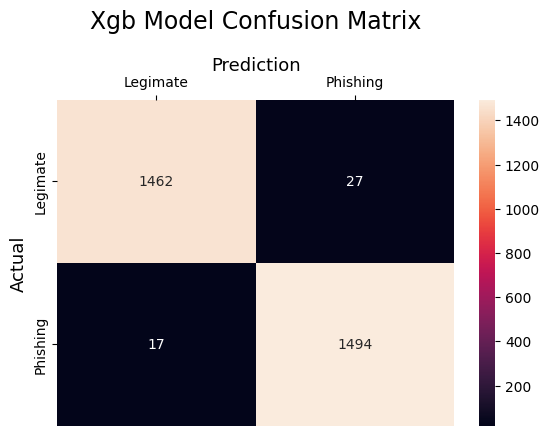

In [26]:
cm = confusion_matrix(y_test, xgb_final_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Xgb Model Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## CNN Complex

Classification Report

In [27]:
print(classification_report(y_test, cnn_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9748    0.9624    0.9686      1489
           1     0.9634    0.9755    0.9694      1511

    accuracy                         0.9690      3000
   macro avg     0.9691    0.9690    0.9690      3000
weighted avg     0.9691    0.9690    0.9690      3000



Dictionary for TP, TP, FP, FN

In [28]:
y_true = np.asarray(y_test).astype(int)
cnn_comparison = pd.DataFrame({'cnn_y_pred': cnn_y_pred, 'y_test': y_true})

cnn_true_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 0)).sum()
print(f"True Positive: {cnn_true_positive}")
cnn_true_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 1)).sum()
print(f"True Negative: {cnn_true_negative}")
cnn_false_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 1)).sum()
print(f"False Positive: {cnn_false_positive}")
cnn_false_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 0)).sum()
print(f"False Negative: {cnn_false_negative}")

True Positive: 1433
True Negative: 1474
False Positive: 37
False Negative: 56


Confusion Matrix

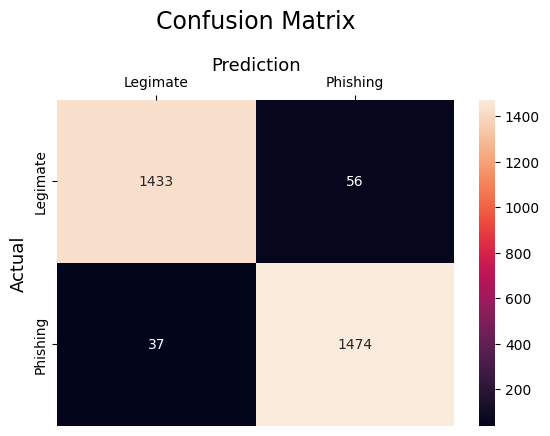

In [29]:
cm = confusion_matrix(y_test, cnn_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Gradient Boosting

Classification Report

In [30]:
print(classification_report(y_test, gbc_pipe_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9838    0.9812    0.9825      1489
           1     0.9815    0.9841    0.9828      1511

    accuracy                         0.9827      3000
   macro avg     0.9827    0.9827    0.9827      3000
weighted avg     0.9827    0.9827    0.9827      3000



Dictionary of TP, TN, FP, FN

In [31]:
gbc_y_pred = gbc_pipe.predict(x_test)
gbc_comparison = pd.DataFrame({'gbc_y_pred': gbc_y_pred, 'y_test': y_test})
gbc_true_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {gbc_true_positive}")
gbc_true_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {gbc_true_negative}")
gbc_false_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {gbc_false_positive}")
gbc_false_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {gbc_false_negative}")

True Positive: 1461
True Negative: 1487
False Positive: 24
False Negative: 28


Confusion Matrix

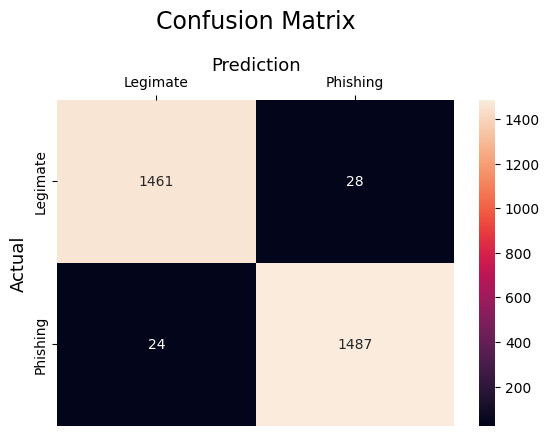

In [32]:
cm = confusion_matrix(y_test, gbc_pipe_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Decision Tree

Classification report

In [33]:
dtc_y_pred = dtc_pipe.predict(x_test)
print(classification_report(y_test, dtc_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9728    0.9590    0.9658      1489
           1     0.9602    0.9735    0.9668      1511

    accuracy                         0.9663      3000
   macro avg     0.9665    0.9663    0.9663      3000
weighted avg     0.9664    0.9663    0.9663      3000



Dictionary of TP, TN, FP, FN

In [34]:
dtc_comparison = pd.DataFrame({'dtc_y_pred': dtc_y_pred, 'y_test': y_test})

dtc_true_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {dtc_true_positive}")
dtc_true_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {dtc_true_negative}")
dtc_false_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {dtc_false_positive}")
dtc_false_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {dtc_false_negative}")

True Positive: 1428
True Negative: 1471
False Positive: 40
False Negative: 61


Confusion Matrix

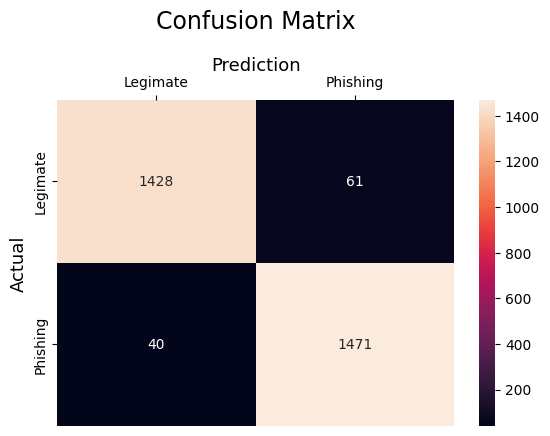

In [35]:
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Stack Model

Classification Report

In [36]:
stack_pred = stack_model.predict(stacked_test)
print(classification_report(y_test, stack_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9858    0.9819    0.9838      1489
           1     0.9822    0.9861    0.9841      1511

    accuracy                         0.9840      3000
   macro avg     0.9840    0.9840    0.9840      3000
weighted avg     0.9840    0.9840    0.9840      3000



Dictionary of TP, TN, FP, FN

In [37]:
stack_comparison = pd.DataFrame({'stack_pred': stack_pred, 'y_test': y_test})

stack_true_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 0)).sum()
print(f"True Positive: {stack_true_positive}")
stack_true_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 1)).sum()
print(f"True Negative: {stack_true_negative}")
stack_false_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 1)).sum()
print(f"False Positive: {stack_false_positive}")
stack_false_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 0)).sum()
print(f"False Negative: {stack_false_negative}")

True Positive: 1462
True Negative: 1490
False Positive: 21
False Negative: 27


Confusion Matrix

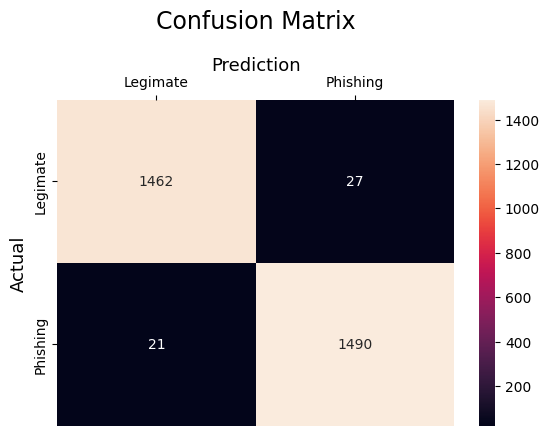

In [38]:
cm = confusion_matrix(y_test, stack_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## ROC Curve & PR Curve

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


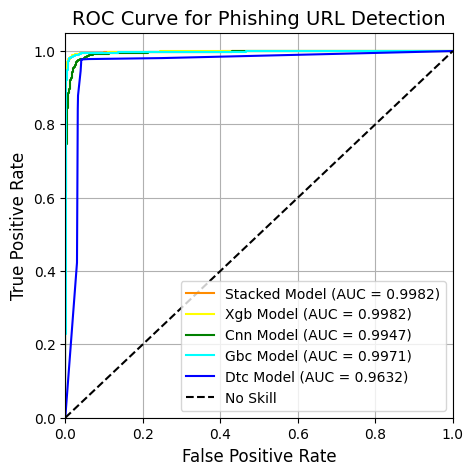

In [39]:
y_prob_stack = stack_model.predict_proba(stacked_test)[:, 1]
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_prob_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)
y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
y_prob_cnn = cnn_model.predict(x_test_cnn)
y_prob_cnn = y_prob_cnn.ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
y_prob_gbc = gbc_pipe.predict_proba(x_test)[:, 1]
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
y_prob_dtc = dtc_pipe.predict_proba(x_test)[:, 1]
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, y_prob_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

plt.figure(figsize=(5, 5))
plt.plot(fpr_stack, tpr_stack, label='Stacked Model (AUC = %0.4f)' % roc_auc_stack, color='darkorange')
plt.plot(fpr_xgb, tpr_xgb, label='Xgb Model (AUC = %0.4f)' % roc_auc_xgb, color='yellow')
plt.plot(fpr_cnn, tpr_cnn, label='Cnn Model (AUC = %0.4f)' % roc_auc_cnn, color='green')
plt.plot(fpr_gbc, tpr_gbc, label='Gbc Model (AUC = %0.4f)' % roc_auc_gbc, color='cyan')
plt.plot(fpr_dtc, tpr_dtc, label='Dtc Model (AUC = %0.4f)' % roc_auc_dtc, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Phishing URL Detection', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

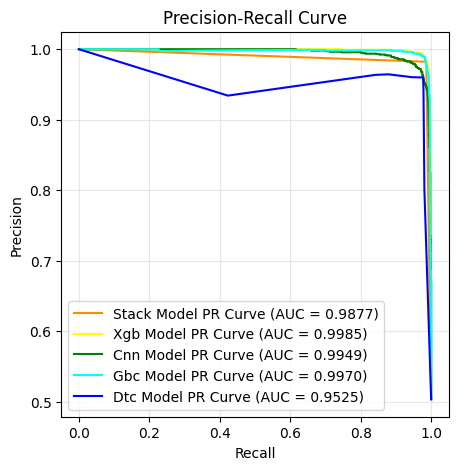

In [40]:
# Precision-Recall Curve
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_pred)
auc_score_stack = auc(recall_stack, precision_stack)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, xgb_probs)
auc_score_xgb = auc(recall_xgb, precision_xgb)
y_prob_cnn = cnn_model_test.ravel()
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_test, y_prob_cnn)
auc_score_cnn = auc(recall_cnn, precision_cnn)
precision_gbc, recall_gbc, thresholds_gbc = precision_recall_curve(y_test, gbc_pipe_prob)
auc_score_gbc = auc(recall_gbc, precision_gbc)
precision_dtc, recall_dtc, thresholds_dtc = precision_recall_curve(y_test, dtc_pipe_prob)
auc_score_dtc = auc(recall_dtc, precision_dtc)

plt.figure(figsize=(5, 5))
plt.plot(recall_stack, precision_stack, label=f'Stack Model PR Curve (AUC = {auc_score_stack:.4f})', color='darkorange')
plt.plot(recall_xgb, precision_xgb, label=f'Xgb Model PR Curve (AUC = {auc_score_xgb:.4f})', color='yellow')
plt.plot(recall_cnn, precision_cnn, label=f'Cnn Model PR Curve (AUC = {auc_score_cnn:.4f})', color='green')
plt.plot(recall_gbc, precision_gbc, label=f'Gbc Model PR Curve (AUC = {auc_score_gbc:.4f})', color='cyan')
plt.plot(recall_dtc, precision_dtc, label=f'Dtc Model PR Curve (AUC = {auc_score_dtc:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

XGBoost contribution weight: 3.9664
CNN contribution weight: 2.9798
GradientBoosting contribution weight: 4.1418
DecisionTree contribution weight: 2.7852


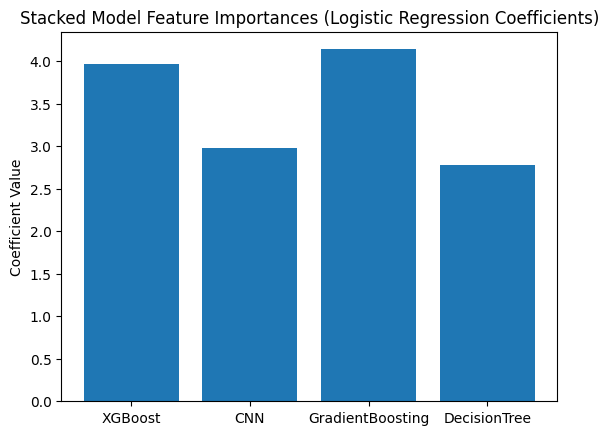

In [41]:
# Logistic Regression Coefficients
importance_scores = stack_model.coef_[0]
stacked_features = ['XGBoost', 'CNN', 'GradientBoosting', 'DecisionTree']
for name, coef in zip(stacked_features, importance_scores):
    print(f"{name} contribution weight: {coef:.4f}")

plt.bar(stacked_features, importance_scores)
plt.title('Stacked Model Feature Importances (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

# Save Model

Saving Final XGB Model

In [67]:
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(sc, "std_scaler.pkl")

new_xgb_size_in_bytes = os.path.getsize('xgb_model.pkl')
new_xgb_size_in_kb = new_xgb_size_in_bytes / 1024
print(f"New Model size: {new_xgb_size_in_kb:.2f} KB")

New Model size: 2740.81 KB


Saving Final CNN Complex Model

In [43]:
cnn_model.save('cnn_complex.h5')

Saving Final Gradient Boosting Model

In [44]:
joblib.dump(gbc_pipe, 'gbc_model.pkl')

['gbc_model.pkl']

Saving Final Decision Tree Model

In [45]:
joblib.dump(dtc_pipe, 'dtc_model.pkl')

['dtc_model.pkl']

# Prediction

In [ ]:
# ================== feature_extractor_48_aligned =================
!pip -q install gradio tldextract
import re, ipaddress, requests, joblib, numpy as np, pandas as pd, gradio as gr
from urllib.parse import urlparse, urljoin, parse_qsl, unquote
from bs4 import BeautifulSoup
from pathlib import Path
import xgboost as xgb
try:
    import tldextract
except ImportError:
    import tldextract

THRESHOLD = 0.50

UA = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124 Safari/537.36"}
REQ_TIMEOUT = 8

FEATURE_ORDER_FROM_ARFF = [
    "NumDots","SubdomainLevel","PathLevel","UrlLength","NumDash","NumDashInHostname",
    "AtSymbol","TildeSymbol","NumUnderscore","NumPercent","NumQueryComponents",
    "NumAmpersand","NumHash","NumNumericChars","NoHttps","RandomString","IpAddress",
    "DomainInSubdomains","DomainInPaths","HttpsInHostname","HostnameLength","PathLength",
    "QueryLength","DoubleSlashInPath","NumSensitiveWords","EmbeddedBrandName",
    "PctExtHyperlinks","PctExtResourceUrls","ExtFavicon","InsecureForms","RelativeFormAction",
    "ExtFormAction","AbnormalFormAction","PctNullSelfRedirectHyperlinks","FrequentDomainNameMismatch",
    "FakeLinkInStatusBar","RightClickDisabled","PopUpWindow","SubmitInfoToEmail","IframeOrFrame",
    "MissingTitle","ImagesOnlyInForm","SubdomainLevelRT","UrlLengthRT","PctExtResourceUrlsRT",
    "AbnormalExtFormActionR","ExtMetaScriptLinkRT","PctExtNullSelfRedirectHyperlinksRT"
]
FEATURE_COLUMNS = FEATURE_ORDER_FROM_ARFF[:]

# Thresholds tuned to be less trigger-happy on legit sites but stricter on camouflages
URL_LEN_T1, URL_LEN_T2 = 54, 75
RES_RT_T1, RES_RT_T2   = 0.50, 0.58
MSL_RT_T1, MSL_RT_T2   = 0.11, 0.87
NULL_RT_T1, NULL_RT_T2 = 0.183, 0.325
MIN_ANCHORS_FOR_RATIO  = 12
MIN_RES_FOR_RATIO      = 10
MIN_NODES_FOR_TITLE    = 12

SHORTENER_ETLDS = {
    "bit.ly","goo.gl","t.co","x.co","is.gd","ow.ly","tinyurl.com","tiny.cc","bit.do","t.ly",
    "rebrand.ly","lnkd.in","fb.me","youtu.be","buff.ly","vk.cc","adf.ly","cutt.us","tr.im"
}
REDIRECTORS = {
    "google.com":["q","url","u"], "google.com.hk":["q","url","u"], "bing.com":["u","url"],
    "duckduckgo.com":["uddg"], "facebook.com":["u","url"], "m.facebook.com":["u","url"],
    "lm.facebook.com":["u","url"], "l.messenger.com":["u","url"], "naver.com":["url","u"],
    "baidu.com":["url","u","wd"], "outlook.com":["url","u","dest","destination"],
    "live.com":["url","u","dest","destination"], "yahoo.com":["u","url"],
    "reddit.com":["url","u","out"], "slack-redir.net":["url"]
}
REDIRECT_PATH_HINTS = {"/url","/l.php","/redir.aspx","/redirect","/out","/r","/link"}

# Neutral infra/CDNs/embeds that shouldn't count as "external" for ratios
NEUTRAL_CDNS = {
    "cloudflare.com","cdnjs.cloudflare.com","cdn.cloudflare.com","cloudfront.net","akamaihd.net","akamaized.net",
    "edgesuite.net","edgekey.net","azureedge.net",
    "jsdelivr.net","cdn.jsdelivr.net","bootstrapcdn.com","stackpath.bootstrapcdn.com","code.jquery.com","unpkg.com",
    "fontawesome.com","kit.fontawesome.com","use.fontawesome.com","typekit.net","adobe.com","adobedtm.com",
    "gstatic.com","googleapis.com","googletagmanager.com","google-analytics.com","googlesyndication.com","doubleclick.net","googletagservices.com",
    "googleadservices.com","googleoptimize.com","youtube.com","ytimg.com","g.doubleclick.net",
    "wp.com","wordpress.com","s.w.org","gravatar.com","disqus.com","wpengine.com",
    "segment.io","newrelic.com","nr-data.net","matomo.cloud","hotjar.com","clarity.ms","polyfill.io","d3js.org","siteimproveanalytics.com",
    "cookielaw.org","cookiebot.com","consentmanager.net","cdn.privacy-mgmt.com","privacy-mgmt.com","onetrust.com","osano.com","tiqcdn.com",
    "brightcove.com","brightcovecdn.com","players.brightcove.net","vimeo.com","player.vimeo.com",
    "facebook.net","connect.facebook.net","staticxx.facebook.com","twitter.com","platform.twitter.com","syndication.twitter.com",
    "instagram.com","cdninstagram.com","linkedin.com","licdn.com","snap.licdn.com","yimg.com",
    "cdn.shopify.com","cloudflareinsights.com","static.oracle.com","oracleimg.com",
    "hsforms.net","hubspot.com","hs-scripts.com","sharethis.com","addthis.com","static.parastorage.com","wixstatic.com"
}
NEUTRAL_SOCIALS = {
    "facebook.com","m.facebook.com","lm.facebook.com","l.messenger.com",
    "twitter.com","x.com","instagram.com","linkedin.com","youtube.com","tiktok.com",
    "wa.me","web.whatsapp.com","telegram.me","t.me"
}

BRAND_AFFINITY = {
    "google.com":{"gstatic.com","googleusercontent.com","googleapis.com","googletagmanager.com","googlesyndication.com","doubleclick.net","youtube.com","g.doubleclick.net","ggpht.com"},
    "github.com":{"githubassets.com","github.githubassets.com","githubusercontent.com","raw.githubusercontent.com"},
    "facebook.com":{"fbcdn.net","facebook.net"},
    "twitter.com":{"twimg.com"},
    "microsoft.com":{"msn.com","live.com","office.com","windows.com"},
    "youtube.com":{"ytimg.com","googlevideo.com","google.com","gstatic.com"},
    "jcp.org":{"oracle.com","oracleimg.com","static.oracle.com","java.net","sun.com"},
}

BRAND_TOKENS = {
    "paypal","facebook","google","gmail","amazon","ebay","apple","icloud","microsoft","live","outlook",
    "chase","citibank","citi","wellsfargo","halifax","santander","hsbc","bankofamerica","boa","ally","regions",
    "skype","netflix","spotify","adp","aol","battle","blizzard","steam","usaa","square-enix","natwest","bbt"
}
SENSITIVE_WORDS = {
    "secure","account","webscr","login","logon","signin","sign-in","bank","banking","confirm",
    "verify","verification","update","password","billing","invoice","pay","payment",
    "compte","moncompte","dossier","espaceclient","clientid","idclient","monespace","freemobile","session","profile.php"
}
OSS_TOKENS = {
    "ubuntu","debian","fedora","centos","arch","redhat","alpine","canonical","launchpad",
    "gcc","glibc","lib","lib32","lib64","x86","x64","amd64","arm","arm64","aarch64","ppc64le","s390x",
    "cross","build","source","files","download","release","stable","dev","pkg","rpm","deb","tar","gz","xz"
}

PUBLIC_SECTOR_SUFFIXES = {
    "gov","gov.cn","gov.uk","gov.au","gov.br","gov.in","gov.za","gov.tw","gov.sg","gov.my",
    "go.jp","go.id","go.kr","gob.mx","gouv.fr",
    "edu","edu.cn","edu.au","edu.br","edu.tw","edu.sg",
    "ac.uk","ac.jp","ac.kr"
}

ENV_PREFIXES = ("e","i","m","dev","stg","stage","test","app","cms","cdn","static")

def _etld(u: str):
    ext = tldextract.extract(u)
    return f"{ext.domain}.{ext.suffix}" if ext.suffix else ext.domain

def _suffix_from_etld(etld: str) -> str:
    parts = etld.split(".")
    return ".".join(parts[1:]) if len(parts) >= 2 else parts[0]

def _same_party(base_etld: str, other_etld: str) -> bool:
    if not base_etld or not other_etld: return False
    if base_etld == other_etld: return True
    if other_etld in BRAND_AFFINITY.get(base_etld, set()): return True
    b_suf = _suffix_from_etld(base_etld).lower()
    o_suf = _suffix_from_etld(other_etld).lower()
    if b_suf == o_suf and (b_suf in PUBLIC_SECTOR_SUFFIXES):
        return True
    def _root(x):
        x = (x or "").split(".")[0]
        return re.sub(rf"^({'|'.join(ENV_PREFIXES)})[-_]?", "", x)
    b, o = _root(base_etld), _root(other_etld)
    return (b and b in other_etld) or (o and o in base_etld)

def _is_neutral_cdn(d: str) -> bool:
    return d in NEUTRAL_CDNS or any(d.endswith("."+n) for n in NEUTRAL_CDNS)

def _is_neutral_social(d: str) -> bool:
    return d in NEUTRAL_SOCIALS or any(d.endswith("."+n) for n in NEUTRAL_SOCIALS)

def _safe_get(u):
    try: return requests.get(u, headers=UA, timeout=REQ_TIMEOUT, verify=True, allow_redirects=True)
    except: return None

def _safe_head(u):
    try: return requests.head(u, headers=UA, timeout=REQ_TIMEOUT, verify=True, allow_redirects=True)
    except: return None

def _frac(v: int, t: int) -> float: return 0.0 if t <= 0 else v/t

def _robust_title(resp) -> str:
    if not resp: return ""
    encs, ct = [], (resp.headers.get("content-type") or "")
    m = re.search(r"charset=([\w\-]+)", ct, re.I)
    if m: encs.append(m.group(1).strip())
    if getattr(resp, "apparent_encoding", None): encs.append(resp.apparent_encoding)
    encs += ["utf-8","latin-1","gb18030"]
    body_txt = None
    for enc in encs:
        try:
            body_txt = resp.content.decode(enc, errors="ignore")
            if "<title" in (body_txt or "").lower(): break
        except: pass
    if body_txt is None:
        try: body_txt = resp.text
        except: body_txt = ""
    try:
        soup = BeautifulSoup(body_txt or "", "html.parser")
        if soup.title and soup.title.string:
            t = soup.title.string.strip()
            if t: return t
    except: pass
    m = re.search(r"<title[^>]*>(.*?)</title>", body_txt or "", re.I|re.S)
    if m:
        t = re.sub(r"\s+", " ", m.group(1)).strip()
        if t: return t
    low = (resp.content or b"").lower()
    a = low.find(b"<title"); b = low.find(b"</title>", a+1) if a != -1 else -1
    if a != -1 and b != -1:
        p = (resp.content[a:b]).find(b">")
        if p != -1:
            raw = resp.content[a+p+1:b]
            for enc in encs:
                try:
                    t = raw.decode(enc, errors="ignore").strip()
                    if t: return t
                except: pass
    return ""

def _looks_like_url(s: str) -> bool:
    return bool(re.match(r'^(?:https?://|//|[a-z0-9\-]+\.[a-z]{2,})(?:[/:?#].*)?$', s, re.I))

def _resolve_redirectors(url: str) -> str:
    if "://" not in url: url = "http://" + url
    try:
        parsed = urlparse(url)
        et = _etld(url)
        if et in SHORTENER_ETLDS:
            r = _safe_head(url)
            if not r or r.url == url: r = _safe_get(url)
            if r and r.url: return r.url
        if et in REDIRECTORS or any(parsed.path.startswith(p) for p in REDIRECT_PATH_HINTS):
            params = dict(parse_qsl(parsed.query, keep_blank_values=True))
            for key in REDIRECTORS.get(et, []) + ["q","url","u","dest","destination","target","to","forward","redirect"]:
                v = params.get(key)
                if not v: continue
                v = unquote(v)
                if _looks_like_url(v):
                    if v.startswith("//"): v = "http:" + v
                    if not v.startswith(("http://","https://")): v = "http://" + v
                    return v
    except: pass
    return url

def extract_48_features(url: str, fetch_html: bool = True) -> pd.DataFrame:
    raw_url = url if "://" in url else "http://" + url
    orig_et = _etld(raw_url)
    eff_url = _resolve_redirectors(raw_url)
    res_et  = _etld(eff_url)
    short_unresolved = (orig_et in SHORTENER_ETLDS and res_et == orig_et)

    parsed = urlparse(eff_url)
    hostname = parsed.hostname or ""
    etld     = _etld(eff_url)
    ext      = tldextract.extract(eff_url)
    subdomain= ext.subdomain or ""
    path     = parsed.path or ""
    query    = parsed.query or ""

    num_dots             = eff_url.count(".")
    subdomain_level      = subdomain.count(".") + (1 if subdomain else 0)
    path_level           = len([p for p in path.split("/") if p])
    url_length           = len(eff_url)
    num_dash             = eff_url.count("-")
    num_dash_host        = hostname.count("-")
    at_symbol            = 1 if "@" in eff_url else 0
    tilde_symbol         = 1 if "~" in eff_url else 0
    num_underscore       = eff_url.count("_")
    num_percent          = eff_url.count("%")
    num_query_components = len([q for q in query.split("&") if q])
    num_amp              = eff_url.count("&")
    num_hash             = eff_url.count("#")
    num_numeric_chars    = sum(c.isdigit() for c in eff_url)
    no_https             = 1 if parsed.scheme.lower() != "https" else 0

    # ---- RandomString & suspicious-URL heuristics
    tokens  = re.split(r"[\-._/=?&%:#]+", (subdomain + "." + path).lower())
    tokens += [v for _, v in parse_qsl(query, keep_blank_values=True)]

    def _tok_ent(s: str) -> float:
        from math import log2
        if not s: return 0.0
        f={}; n=len(s)
        for ch in s: f[ch]=f.get(ch,0)+1
        return -sum((c/n)*log2(c/n) for c in f.values())

    def _is_rand(t):
        if not t: return False
        s = str(t).lower()
        if s in OSS_TOKENS: return False
        if s.isdigit(): return len(s) >= 7
        if len(s) < 14: return False
        if any(s == k or k in s for k in OSS_TOKENS): return False
        if re.fullmatch(r"\d+(?:[._-]\d+){1,4}", s): return False
        if re.fullmatch(r"(19|20)\d{6}", s): return False  # YYYYMMDD
        if re.fullmatch(r"[a-z]+(?:\d+[a-z]*)+", s) and any(k in s for k in ("ubuntu","lib","gcc")): return False
        ent = _tok_ent(s)
        has_a = any(c.isalpha() for c in s); has_d = any(c.isdigit() for c in s)
        return has_a and has_d and (ent >= 3.8)

    suspect = sum(_is_rand(t) for t in tokens)

    # numeric-only short path (allow dotted segments like ".1")
    segs = [seg for seg in path.split("/") if seg]
    def _is_numseg(seg): return bool(re.fullmatch(r"\.?\d{1,6}", seg))
    if no_https and len(segs) >= 2 and all(_is_numseg(seg) for seg in segs) and len(re.sub(r"\D","", "".join(segs))) <= 6:
        suspect += 2

    # long hex directory slugs → strong signal (common in kits)
    for seg in segs:
        if re.fullmatch(r"[0-9a-fA-F]{24,}", seg):
            suspect += 2
            break

    # unresolved shortener → suspicious
    if short_unresolved:
        suspect += 2

    random_string = 1 if suspect >= 2 else 0

    def _is_ip(h):
        try: ipaddress.ip_address((h or "").split(":")[0]); return 1
        except: return 0
    ip_address = _is_ip(hostname)

    reg_label = (ext.domain or "").lower()
    root_lbl  = re.sub(rf"^({'|'.join(ENV_PREFIXES)})[-_]?", "", reg_label)
    sub_tokens  = [t for t in re.split(r"[^a-z0-9]+", subdomain.lower()) if t]
    path_tokens = [t for t in re.split(r"[^a-z0-9]+", path.lower()) if t]
    domain_in_subdomains = 1 if ((reg_label and reg_label in sub_tokens) or (root_lbl and root_lbl in sub_tokens)) else 0

    base_suffix = ext.suffix.lower()
    domain_in_paths = 1 if ((reg_label and reg_label in path_tokens) or (root_lbl and root_lbl in path_tokens)) else 0
    if domain_in_paths and (base_suffix.startswith("org") or base_suffix.startswith("edu") or base_suffix.startswith("gov")):
        domain_in_paths = 0

    https_in_hostname    = 1 if "https" in (hostname or "").lower() else 0
    hostname_length      = len(hostname)
    path_length          = len(path)
    query_length         = len(query)
    double_slash_in_path = 1 if "//" in path else 0
    num_sensitive_words  = sum(1 for w in SENSITIVE_WORDS if w in eff_url.lower())

    # ---------- HTML defaults ----------
    embedded_brand_name = 0
    pct_ext_hyperlinks  = 0.0
    pct_ext_resources   = 0.0
    ext_favicon         = 0
    insecure_forms      = 0
    relative_form_action= 0
    ext_form_action     = 0
    abnormal_form_action= 0
    pct_null_self_redir = 0.0
    freq_domain_mismatch= 0
    fake_link_statusbar = 0
    right_click_disabled= 0
    popup_window        = 0
    submit_info_to_email= 0
    iframe_or_frame     = 0
    missing_title       = 0
    images_only_in_form = 0
    ext_msl_frac        = 0.0

    # --- brand/domain camo in subdomain/path/query ---
    def _word_hit(needle, hay):
        # boundary match OR short-substring match in subdomain tokens
        if re.search(rf'(?<![a-z0-9]){re.escape(needle)}(?![a-z0-9])', hay): return True
        # allow e.g. "steamtourny" (brand at token edge or small augmentation)
        for tok in re.split(r"[^a-z0-9]+", hay):
            if not tok: continue
            if tok.startswith(needle) or tok.endswith(needle):
                if len(tok) <= len(needle) + 4:  # small decoration around the brand
                    return True
        return False

    sub_lc   = (subdomain or "").lower()
    pathq_lc = (path + ("?" + query if query else "")).lower()
    reg_label_lc = (ext.domain or "").lower()
    for bt in BRAND_TOKENS:
        if _word_hit(bt, reg_label_lc) or reg_label_lc.endswith(bt) or reg_label_lc.startswith(bt):
            continue
        if _word_hit(bt, sub_lc) or _word_hit(bt, pathq_lc):
            embedded_brand_name = 1
            break

    # foreign domain strings embedded in subdomain/path/query (not anchors)
    def _mark_foreign_domains(text: str):
        nonlocal freq_domain_mismatch, embedded_brand_name
        for m in re.findall(r'([a-z0-9\-]+(?:\.[a-z0-9\-]+)+)', text, flags=re.I):
            try:
                dd = _etld("http://" + m)
            except:
                continue
            if dd and not (_same_party(etld, dd) or _is_neutral_cdn(dd) or _is_neutral_social(dd)):
                freq_domain_mismatch = 1
                root = (dd.split(".")[0] or "")
                if len(root) >= 4:
                    embedded_brand_name = 1
    _mark_foreign_domains(sub_lc)
    _mark_foreign_domains(pathq_lc)

    # query URLs pointing elsewhere -> mismatch + possible brand
    for k, v in parse_qsl(query, keep_blank_values=True):
        v_dec = unquote(v)
        if re.match(r'^(?:https?://|//|[a-z0-9\-]+\.[a-z]{2,})', v_dec, re.I):
            if v_dec.startswith("//"): v_dec = "http:" + v_dec
            if not v_dec.startswith(("http://","https://")): v_dec = "http://" + v_dec
            try:
                ad = _etld(v_dec)
                if not (_same_party(etld, ad) or _is_neutral_cdn(ad) or _is_neutral_social(ad)):
                    freq_domain_mismatch = 1
                    for bt in BRAND_TOKENS:
                        if _word_hit(bt, v_dec.lower()):
                            embedded_brand_name = 1
                            break
            except: pass

    # fetch & verify HTML
    soup = None
    is_html = False
    resp = None
    if fetch_html:
        resp = _safe_get(eff_url)
        if resp:
            ctype = (resp.headers.get("content-type") or "").lower()
            head  = (resp.text or "")[:2048].lower()
            is_html = ("text/html" in ctype) or ("<html" in head) or ("<head" in head)
            if is_html and resp.text:
                soup = BeautifulSoup(resp.text, "html.parser")

    if is_html:
        anchors = soup.find_all("a", href=True) if soup else []
        imgs    = soup.find_all("img", src=True) if soup else []
        scripts = soup.find_all("script", src=True) if soup else []
        links   = [lnk for lnk in (soup.find_all("link", href=True) if soup else [])
                   if any(k in " ".join((lnk.get("rel") or [])).lower() for k in ("stylesheet","icon"))]
        iframes = soup.find_all("iframe", src=True) if soup else []
        frames  = soup.find_all("frame", src=True) if soup else []
        node_count = len(anchors)+len(imgs)+len(scripts)+len(links)+len(iframes)+len(frames)

        title_text = _robust_title(resp)
        missing_title = 0 if node_count < MIN_NODES_FOR_TITLE else (1 if not title_text else 0)

        total_anchors = len(anchors)
        http_count = ext_count = null_count = 0
        anchor_domains = []
        for a in anchors:
            href = (a.get("href") or "").strip().lower()
            if not href or href == "#" or urljoin(eff_url, href).split("#")[0] == eff_url.split("#")[0]:
                null_count += 1; continue
            if href.startswith(("mailto:", "tel:", "javascript:")): continue
            absu = urljoin(eff_url, href)
            if absu.startswith(("http://","https://")):
                http_count += 1
                ad = _etld(absu)
                if _is_neutral_cdn(ad) or _is_neutral_social(ad) or _same_party(etld, ad):
                    pass
                else:
                    ext_count += 1; anchor_domains.append(ad)

        if total_anchors < MIN_ANCHORS_FOR_RATIO:
            pct_ext_hyperlinks  = 0.0
            pct_null_self_redir = 0.0
        else:
            pct_ext_hyperlinks  = _frac(ext_count, total_anchors)
            pct_null_self_redir = _frac(null_count, total_anchors)

        res_total = res_ext = 0
        def _count_ext(nodes, attr):
            nonlocal res_total, res_ext
            for n in nodes:
                u = n.get(attr)
                if not u: continue
                absu = urljoin(eff_url, u)
                if not absu.startswith(("http://","https://","/")) and not u.startswith("//"):
                    continue
                res_total += 1
                ad = _etld(absu)
                if not (_same_party(etld, ad) or _is_neutral_cdn(ad) or _is_neutral_social(ad)):
                    res_ext += 1
        _count_ext(imgs,"src"); _count_ext(scripts,"src"); _count_ext(links,"href")
        _count_ext(iframes,"src"); _count_ext(frames,"src")

        if res_total < MIN_RES_FOR_RATIO:
            pct_ext_resources = 0.0; ext_msl_frac = 0.0
        else:
            pct_ext_resources = _frac(res_ext, res_total)
            msl_total = len(links) + len(scripts); msl_ext = 0
            for n in links:
                u = n.get("href");      ad = _etld(urljoin(eff_url, u)) if u else ""
                if u and not (_same_party(etld, ad) or _is_neutral_cdn(ad) or _is_neutral_social(ad)): msl_ext += 1
            for n in scripts:
                u = n.get("src");       ad = _etld(urljoin(eff_url, u)) if u else ""
                if u and not (_same_party(etld, ad) or _is_neutral_cdn(ad) or _is_neutral_social(ad)): msl_ext += 1
            ext_msl_frac = _frac(msl_ext, msl_total)

        fav_url = None
        for el in links:
            rel = " ".join(el.get("rel") or []).lower()
            if "icon" in rel: fav_url = el.get("href"); break
        if fav_url:
            favd = _etld(urljoin(eff_url, fav_url))
            ext_favicon = 0 if (_same_party(etld, favd) or _is_neutral_cdn(favd) or _is_neutral_social(favd)) else 1

        forms = soup.find_all("form") if soup else []
        if forms:
            for f in forms:
                action = (f.get("action") or "").strip()
                low = action.lower()
                if low in ("", "#", "about:blank") or low.startswith("javascript:"):
                    abnormal_form_action = 1
                if action and not action.startswith(("http://", "https://")):
                    relative_form_action = 1
                if action.startswith(("http://","https://")):
                    ad = _etld(action)
                    if not (_same_party(etld, ad) or _is_neutral_cdn(ad) or _is_neutral_social(ad)):
                        ext_form_action = 1
                if action.startswith("http://"): insecure_forms = 1
                if "mailto:" in low: submit_info_to_email = 1
                text_bits = "".join(t for t in f.strings if t.strip())
                if (not bool(text_bits)) and (f.find("img") or f.find("input", {"type":"image"})):
                    images_only_in_form = 1

        # FrequentDomainNameMismatch (stricter)
        if total_anchors >= MIN_ANCHORS_FOR_RATIO and anchor_domains:
            from collections import Counter
            filtered = [d for d in anchor_domains if not (_is_neutral_cdn(d) or _is_neutral_social(d))]
            if filtered and total_anchors >= 12:
                mf, cnt = Counter(filtered).most_common(1)[0]
                if not _same_party(etld, mf):
                    share = cnt / max(1, total_anchors)
                    if share >= 0.60:
                        freq_domain_mismatch = 1
                        mf_main = mf.split(".")[0]
                        COMMON = {"facebook","twitter","instagram","youtube","linkedin","tiktok",
                                  "google","gstatic","doubleclick","cloudflare","wp","wordpress",
                                  "gravatar","disqus","typekit"}
                        if mf_main and len(mf_main) >= 4 and mf_main not in COMMON:
                            if (mf_main in subdomain.lower()) or (mf_main in path.lower()):
                                embedded_brand_name = 1

        page_text = (soup.get_text(" ", strip=False) if soup else "").lower()
        if "onmouseover" in page_text and "window.status" in page_text: fake_link_statusbar = 1
        if re.search(r"event\.button\s*==\s*2", page_text):             right_click_disabled = 1
        if re.search(r"(window\.open\s*\(|alert\s*\()", page_text):      popup_window = 1

        iframe_or_frame = 1 if (len(iframes)+len(frames)) else 0

    # ---- Ratings (RT) exactly mapped to {-1,0,1}
    subdomain_level_rt = 1 if subdomain_level <= 1 else (0 if subdomain_level == 2 else -1)
    url_length_rt      = 1 if url_length < URL_LEN_T1 else (0 if url_length <= URL_LEN_T2 else -1)
    pct_ext_res_rt     = 1 if pct_ext_resources <= RES_RT_T1 else (0 if pct_ext_resources <= RES_RT_T2 else -1)
    if abnormal_form_action and relative_form_action: abn_ext_form_r = -1
    elif ext_form_action:                               abn_ext_form_r = 0
    else:                                               abn_ext_form_r = 1
    ext_msl_rt        = 1 if ext_msl_frac <= MSL_RT_T1 else (0 if ext_msl_frac <= MSL_RT_T2 else -1)
    pct_null_self_rt  = 1 if pct_null_self_redir <= NULL_RT_T1 else (0 if pct_null_self_redir <= NULL_RT_T2 else -1)

    row = [
        int(num_dots), int(subdomain_level), int(path_level), int(url_length), int(num_dash), int(num_dash_host),
        int(at_symbol), int(tilde_symbol), int(num_underscore), int(num_percent), int(num_query_components),
        int(num_amp), int(num_hash), int(num_numeric_chars), int(no_https), int(random_string), int(ip_address),
        int(domain_in_subdomains), int(domain_in_paths), int(https_in_hostname), int(hostname_length), int(path_length),
        int(query_length), int(double_slash_in_path), int(num_sensitive_words), int(embedded_brand_name),
        float(pct_ext_hyperlinks), float(pct_ext_resources), int(ext_favicon), int(insecure_forms), int(relative_form_action),
        int(ext_form_action), int(abnormal_form_action), float(pct_null_self_redir), int(freq_domain_mismatch),
        int(fake_link_statusbar), int(right_click_disabled), int(popup_window), int(submit_info_to_email), int(iframe_or_frame),
        int(missing_title), int(images_only_in_form), int(subdomain_level_rt), int(url_length_rt), int(pct_ext_res_rt),
        int(abn_ext_form_r), int(ext_msl_rt), int(pct_null_self_rt)
    ]
    return pd.DataFrame([row], columns=FEATURE_COLUMNS)


def predict_url_phish(url, xgb_model, threshold: float = THRESHOLD):
    feats = extract_48_features(url, fetch_html=True)
    X = feats.values.astype(float)
    Xs = sc.transform(X)  # using the fitted StandardScaler you loaded

    proba = xgb_model.predict_proba(Xs)  # works for Pipeline or bare estimator

    # Get the final classifier object to read `classes_` safely
    clf = xgb_model.named_steps["xgbclassifier"] if hasattr(xgb_model, "named_steps") else xgb_model
    classes = clf.classes_

    phish_col = (list(classes).index(1) if 1 in set(classes)
                 else list(classes).index("phishing") if "phishing" in set(classes)
                 else proba.shape[1] - 1)

    prob_phish = float(proba[0, phish_col])
    label_id   = int(prob_phish >= threshold)
    label      = "Phishing" if label_id else "Legit"

    return {"features": feats, "prob_phish": prob_phish, "label_id": label_id, "label": label}

#====================================== END =================================================

MODEL_PATH = Path("/content/xgb_model.pkl")
SCALER_PATH = Path("/content/std_scaler.pkl")
if not MODEL_PATH.exists():
    raise FileNotFoundError("xgb_model.pkl not found. Upload it to the Colab file pane.")
if not SCALER_PATH.exists():
    raise FileNotFoundError("std_scaler.pkl not found. Save and upload your fitted scaler.")

xgb_model = joblib.load(MODEL_PATH)
sc        = joblib.load(SCALER_PATH)

def predict_url(url: str, threshold: float = THRESHOLD):
    url = (url or "").strip()
    if not url:
        return "Please enter a URL.", ""

    # Basic URL format validation
    url_pattern = re.compile(
        r'^(https?:\/\/)?'                 # http:// or https:// (optional)
        r'([a-zA-Z0-9-]+\.)+[a-zA-Z]{2,}'  # domain like example.com
        r'(:\d+)?'                         # optional port
        r'(\/.*)?$'                        # optional path
    )
    if not url_pattern.match(url):
        return "❌ Invalid URL format. Please try again.", ""

    res = predict_url_phish(url, xgb_model=xgb_model, threshold=threshold)

    label_txt  = "🟥 Phishing" if res["label_id"] == 1 else "🟩 Legit"
    return label_txt, f"{res['prob_phish']:.3f}"

BG_URL = "https://raw.githubusercontent.com/NHCH1/DLI/refs/heads/main/internet-security-protection-from-hacker-attacking-cyber-attack-and-network-security-concept-free-photo.jpg"

# 3) Build CSS with the BG_URL inserted
css = """
/* =============== Page background =============== */
.gradio-container{
  background-image: url('{BG_URL}');
  background-size: cover;
  background-position: center;
  background-attachment: fixed;
}
html, body{ background: transparent !important; }

/* =============== Glow panel =============== */
#glow-panel{
  position: relative;
  margin: 24px auto;
  max-width: 1200px;
  padding: 22px;
  border-radius: 24px;
  background: transparent;
}
#glow-panel::before{
  content:"";
  position:absolute;
  inset:-200px;
  border-radius: 48px;
  pointer-events:none;
  z-index:0;
  background: radial-gradient(farthest-side at 50% 35%,
    rgba(255,255,255,.92) 0%,
    rgba(255,255,255,.70) 25%,
    rgba(255,255,255,.40) 55%,
    rgba(255,255,255,.18) 78%,
    rgba(255,255,255,.08) 90%,
    rgba(255,255,255,0) 100%);
  filter: blur(36px);
}
#glow-panel > *{ position:relative; z-index:1; }

/* strip default boxes inside the panel */
#glow-panel *:where(:not(input):not(textarea):not(button)){
  background: transparent !important;
  box-shadow: none !important;
  border-color: transparent !important;
}

/* =============== Inputs =============== */
#url-box :is(input,textarea),
#result-box :is(input,textarea),
#prob-box :is(input,textarea){
  background: rgba(15,23,42,.80) !important; /* dark glass */
  color: #F8FAFC !important;
  border: 1px solid rgba(255,255,255,.25) !important;
  border-radius: 12px !important;
  backdrop-filter: blur(3px);
  font-weight: 400 !important;               /* keep input text normal */
}
#url-box :is(input,textarea)::placeholder,
#result-box :is(input,textarea)::placeholder,
#prob-box :is(input,textarea)::placeholder{
  color: rgba(248,250,252,.60) !important;
  font-weight: 400 !important;               /* keep placeholder normal */
}

/* “cards” around result & probability */
#result-box, #prob-box{
  background: rgba(255,255,255,.14) !important;
  border: 1px solid rgba(0,0,0,.06) !important;
  border-radius: 14px !important;
  padding: 0 !important;
  box-shadow: 0 1px 0 rgba(255,255,255,.22) inset;
}


/* =============== Buttons =============== */
#btn-detect,
#btn-clear{
  color:#fff !important;
  border:none !important;
  border-radius:14px !important;
  padding:10px 16px !important;
  font-weight:700 !important;
  transition: background .18s ease, transform .18s ease;
}
#btn-detect{ background:#e11d29 !important; }      /* base red   */
#btn-clear { background:#15803d !important; }      /* base green */

/* distinct hover colors (kept) */
#btn-detect:hover{ background:#f43f5e !important; transform: translateY(-1px); }
#btn-clear:hover { background:#10b981 !important; transform: translateY(-1px); }

/* =============== Layout / spacing =============== */
#btn-row,
#btn-row > div{ display:flex !important; gap:24px !important; }
#btn-row > *{ flex:1 1 0 !important; }
#btn-row .gr-button{ width:100% !important; }
#btn-row{ padding-inline:12px !important; }

#result-container{ margin-top:28px; padding-inline:12px !important; }
#results-row{ display:flex !important; gap:24px !important; align-items:stretch !important; }
#results-row > *{ flex:1 1 0 !important; }


/* === Make the three section titles black, bold, and a bit larger === */

#url-box :is([data-testid="block-label"], .label, label),
#url-box :is([data-testid="block-label"], .label, label) *,

#result-box :is([data-testid="block-label"], .label, label),
#result-box :is([data-testid="block-label"], .label, label) *,

#prob-box :is([data-testid="block-label"], .label, label),
#prob-box :is([data-testid="block-label"], .label, label) * {
  color: #000 !important;
  font-weight: 800 !important;                 /* bold */
  font-size: clamp(1.12rem, 1rem + 0.5vw, 1.3rem) !important; /* a bit larger */
  line-height: 1.35 !important;
  letter-spacing: .2px !important;
  opacity: 1 !important;
  text-shadow: none !important;
}

/* Force typed input text to white (also cursor) */
#url-box input[type="text"],
#url-box textarea,
#result-box input[type="text"],
#result-box textarea,
#prob-box input[type="text"],
#prob-box textarea {
  color: #ffffff !important;              /* normal CSS text color */
  -webkit-text-fill-color: #ffffff !important; /* Safari/Chrome fix */
  caret-color: #ffffff !important;        /* make cursor white */
  font-weight: 200 !important;
}

"""
css = css.replace("{BG_URL}", BG_URL)


with gr.Blocks(css=css, title="URL Phishing Detector") as demo:
    gr.Markdown("<h1 style='text-align:center;color:#DC3C22'>🔍 URL Phishing Detector</h1>")
    with gr.Group(elem_id="glow-panel"):
        with gr.Row(elem_id="url-container"):
            url_in = gr.Textbox(
                label="Please enter URL",
                placeholder="http://example.com/login",
                elem_id="url-box"
            )

        with gr.Row(elem_id="btn-row"):
            btn_detect = gr.Button("Start Detect", elem_id="btn-detect")
            btn_clear  = gr.Button("Clear",        elem_id="btn-clear")

        with gr.Group(elem_id="result-container"):
            with gr.Row(elem_id="results-row"):
                with gr.Column(scale=1):
                    with gr.Group(elem_id="result-box"):
                        label_out = gr.Textbox(label="Result", interactive=False)
                with gr.Column(scale=1):
                    with gr.Group(elem_id="prob-box"):
                        prob_out  = gr.Textbox(label="Phishing probability", interactive=False)

    btn_detect.click(predict_url, [url_in], [label_out, prob_out])
    btn_clear.click(lambda: ("",""), None, [label_out, prob_out])
    btn_clear.click(lambda: "", None, url_in)

demo.launch(share=True, inline=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f5d3e5af41ded0f1fb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# XGBoost - Liong Chi Teng - TP065355

Data processing

In [49]:
xgb_feature = data.drop([48],axis=1)
print(xgb_feature)
xgb_target = data[48]
print(xgb_target)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

Retest original paper code

In [50]:
ind_xg = XGBClassifier(use_label_encoder =False, eval_metric='logloss')
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
xgb_scores={'accuracy': make_scorer(accuracy_score),
            'recall' : make_scorer(recall_score),
            'precision':make_scorer(precision_score),
            'gmean': make_scorer(geometric_mean_score),
            'f1':make_scorer(f1_score),
            'roc': make_scorer(roc_auc_score)
            }
from sklearn.model_selection import cross_validate
ind_xg_result = cross_validate(ind_xg, xgb_feature, xgb_target, cv = 10, scoring=xgb_scores)
df = pd.DataFrame(ind_xg_result)

ori_xgb_scores = df.mean(axis=0)
ori_xgb_acc  = ori_xgb_scores['test_accuracy']
ori_xgb_prec = ori_xgb_scores['test_precision']
ori_xgb_rec  = ori_xgb_scores['test_recall']
ori_xgb_f1   = ori_xgb_scores['test_f1']
ori_xgb_roc  = ori_xgb_scores['test_roc']

df.mean(axis=0)

,0
fit_time,4.118053
score_time,0.075075
test_accuracy,0.982600
test_recall,0.980000
test_precision,0.985211
test_gmean,0.982576
test_f1,0.982559
test_roc,0.982600


Evaluating inference time and model size

In [51]:
ind_xg.fit(xgb_feature, xgb_target)

start_time = time.time()
_ = ind_xg.predict_proba(xgb_feature)
end_time = time.time()
ori_xgb_total_inference_time = end_time - start_time
ori_xgb_avg_inference_time = ori_xgb_total_inference_time / len(xgb_feature)
print(f"Total Inference time: {ori_xgb_total_inference_time:.8f} seconds")
print(f"Average per sample:     {ori_xgb_avg_inference_time:.8f} seconds")

ind_xg.save_model('ori_xgb.json')
ori_xgb_size_in_bytes = os.path.getsize('ori_xgb.json')
ori_xgb_size_in_kb = ori_xgb_size_in_bytes / 1024
print(f"Model size: {ori_xgb_size_in_kb:.2f} KB")

Total Inference time: 0.03228498 seconds
Average per sample:     0.00000323 seconds
Model size: 292.28 KB


Side by side comparison

In [52]:
xgb_comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Total Inference Time (s)", "Avg Inference Time (s)", "Model Size (KB)"],

    "Old (ind_xg)": [
        f"{ori_xgb_acc:.4f}",
        f"{ori_xgb_prec:.4f}",
        f"{ori_xgb_rec:.4f}",
        f"{ori_xgb_f1:.4f}",
        f"{ori_xgb_roc:.4f}",
        f"{ori_xgb_total_inference_time:.8f}",
        f"{ori_xgb_avg_inference_time:.8f}",
        f"{ori_xgb_size_in_kb:.2f}"
    ],

    "New (xgb_model)": [
        f"{xgb_acc:.4f}",
        f"{xgb_prec:.4f}",
        f"{xgb_rec:.4f}",
        f"{xgb_f1:.4f}",
        f"{xgb_roc_auc:.4f}",
        f"{xgb_inference_time:.8f}",
        f"{xgb_avg_time:.8f}",
        f"{new_xgb_size_in_kb:.2f}"
    ]
}

pd.DataFrame(xgb_comparison_data)

,Metric,Old (ind_xg),New (xgb_model)
0,Accuracy,0.9826,0.9853
1,Precision,0.9852,0.9822
2,Recall,0.9800,0.9887
3,F1-score,0.9826,0.9855
4,ROC-AUC,0.9826,0.9982
5,Total Inference Time (s),0.03228498,0.12942076
6,Avg Inference Time (s),0.00000323,0.00004314
7,Model Size (KB),292.28,2740.81


# CNN Complex - Ng Hooi Chi - TP065587

Setup

In [63]:
import requests
import math, tensorflow as tf
from IPython.display import display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Embedding

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

cnn_url = "https://raw.githubusercontent.com/NHCh1/DLI/main/cnn_small_dataset"

cnn_params = {
    'loss_function': 'binary_crossentropy',
    'optimizer': 'adam',
    'sequence_length': 200,
    'batch_size': 256,
    'categories': ['phishing', 'legitimate'],
    'epoch': 25,
    'embedding_dimension': 100,
    'dataset_dir': f"{cnn_url}".rstrip("/")
}

# Custom callback to track epoch times
class CustomCallback:
    def __init__(self):
        self.epoch_times = []
    def on_epoch_begin(self):
        self.epoch_time_start = time.time()
    def on_epoch_end(self):
        self.epoch_times.append(time.time() - self.epoch_time_start)

Data Processing

In [64]:
def load_data(dataset_dir):
    def read_lines(name: str):
        if dataset_dir.startswith("http"):
            url = f"{dataset_dir.rstrip('/')}/{name}"
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            r.encoding = "utf-8"
            lines = [ln.strip() for ln in r.text.splitlines() if ln.strip()]
            if not lines:
                raise ValueError(f"{url} is empty or unreadable.")
            return lines
        else:
            with open(os.path.join(dataset_dir, name), encoding="utf-8") as f:
                return [ln.strip() for ln in f if ln.strip()]

    train = read_lines('train.txt')
    val   = read_lines('val.txt')
    test  = read_lines('test.txt')

    raw_x_train = [line.split("\t", 1)[1] for line in train]
    raw_y_train = [line.split("\t", 1)[0] for line in train]
    raw_x_val   = [line.split("\t", 1)[1] for line in val]
    raw_y_val   = [line.split("\t", 1)[0] for line in val]
    raw_x_test  = [line.split("\t", 1)[1] for line in test]
    raw_y_test  = [line.split("\t", 1)[0] for line in test]

    tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
    tokenizer.fit_on_texts(raw_x_train + raw_x_val + raw_x_test)
    cnn_params['char_index'] = tokenizer.word_index

    cnn_feature_train = pad_sequences(tokenizer.texts_to_sequences(raw_x_train), maxlen=cnn_params['sequence_length'])
    cnn_feature_val   = pad_sequences(tokenizer.texts_to_sequences(raw_x_val),   maxlen=cnn_params['sequence_length'])
    cnn_feature_test  = pad_sequences(tokenizer.texts_to_sequences(raw_x_test),  maxlen=cnn_params['sequence_length'])

    encoder = LabelEncoder()
    encoder.fit(cnn_params['categories'])
    assert encoder.transform(['legitimate','phishing']).tolist() == [0,1], encoder.classes_

    y_train_oh = to_categorical(encoder.transform(raw_y_train), num_classes=2)
    y_val_oh   = to_categorical(encoder.transform(raw_y_val),   num_classes=2)
    y_test_oh  = to_categorical(encoder.transform(raw_y_test),  num_classes=2)

    return (cnn_feature_train, y_train_oh), (cnn_feature_val, y_val_oh), (cnn_feature_test, y_test_oh), tokenizer.word_index

# Load data
(cnn_feature_train, y_train_oh), (cnn_feature_val, y_val_oh), (cnn_feature_test, y_test_oh), char_index = load_data(cnn_params['dataset_dir'])

# Peek raw data
def peek_dataset(dataset_dir, n=5):
    def read_lines(name: str):
        if dataset_dir.startswith("http"):
            url = f"{dataset_dir.rstrip('/')}/{name}"
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            r.encoding = "utf-8"
            return [ln.strip() for ln in r.text.splitlines() if ln.strip()]
        else:
            with open(os.path.join(dataset_dir, name), encoding="utf-8") as f:
                return [ln.strip() for ln in f if ln.strip()]

    def to_df(lines):
        parts = [ln.split("\t", 1) for ln in lines]
        return pd.DataFrame(parts, columns=["label", "text"])

    train_df = to_df(read_lines("train.txt"))
    val_df   = to_df(read_lines("val.txt"))
    test_df  = to_df(read_lines("test.txt"))

    for name, df in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
        print(f"\n[{name}] rows={df.shape[0]}, cols={df.shape[1]}")
        print("label counts:", df["label"].value_counts().to_dict())
        display(df.head(n))

peek_dataset(cnn_params["dataset_dir"])

print("\nEncoded shapes (after tokenization & padding):")
print("cnn_feature_train:", cnn_feature_train.shape, "  y_train_oh:", y_train_oh.shape)
print("cnn_feature_val:  ", cnn_feature_val.shape,   "  y_val_oh:  ", y_val_oh.shape)
print("cnn_feature_test: ", cnn_feature_test.shape,  "  y_test_oh: ", y_test_oh.shape)


[TRAIN] rows=364199, cols=2
label counts: {'legitimate': 201736, 'phishing': 162463}


,label,text
0,legitimate,https://oregonstateparks.org/index.cfm?do=geti...
1,phishing,http://business.hsbc.com.camaract.mobi/system_...
2,phishing,http://facebook.com-source-page.com/help/conta...
3,legitimate,http://michaelnielsen.org/blog/lecture-course-...
4,phishing,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...



[VAL] rows=104576, cols=2
label counts: {'legitimate': 57927, 'phishing': 46649}


,label,text
0,legitimate,https://www.hotelcareer.de/jobs/parkhotel-adle...
1,legitimate,https://www.ramtrucks.com/2018/ram-promaster-c...
2,phishing,http://www.paypal-com.org/secure/4eec645d077d6...
3,legitimate,https://www.smore.com/ghq0
4,phishing,http://telcelrecargas.idohost.com/



[TEST] rows=51510, cols=2
label counts: {'legitimate': 28532, 'phishing': 22978}


,label,text
0,phishing,http://www.bartekbitner.pl/libraries/fof/-/din7
1,phishing,http://www.isalechina.com/_db_backups/SecureDo...
2,legitimate,https://eheadspace.org.au/headspace-centres/mu...
3,phishing,http://www.idolhairsalon.com/google/free/free2...
4,legitimate,https://hedgebrook.org/six-questions-for-hanna...



Encoded shapes (after tokenization & padding):
cnn_feature_train: (364199, 200)   y_train_oh: (364199, 2)
cnn_feature_val:   (104576, 200)   y_val_oh:   (104576, 2)
cnn_feature_test:  (51510, 200)   y_test_oh:  (51510, 2)


Import Original Paper Code

In [65]:
class DlModels:
    def __init__(self, categories, embed_dim, sequence_length):
        self.categories = categories
        self.embed_dim = embed_dim
        self.sequence_length = sequence_length

    def cnn_complex(self, char_index):
        model = Sequential()
        voc_size = len(char_index.keys())

        model.add(Embedding(voc_size + 1, self.embed_dim, input_length=self.sequence_length))
        model.add(Conv1D(128, 3, activation='tanh'))
        model.add(MaxPooling1D(3))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 7, activation='tanh', padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 5, activation='tanh', padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 3, activation='tanh', padding='same'))
        model.add(MaxPooling1D(3))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 5, activation='tanh', padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 3, activation='tanh', padding='same'))
        model.add(MaxPooling1D(3))
        model.add(Dropout(0.2))

        model.add(Conv1D(128, 3, activation='tanh', padding='same'))
        model.add(MaxPooling1D(3))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(len(self.categories), activation='sigmoid'))
        return model

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

class TimerCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        print(f" | Epoch {epoch + 1} took {time.time() - self.start_time:.2f} seconds")

# Build, compile, train
dl_model = DlModels(cnn_params['categories'], cnn_params['embedding_dimension'], cnn_params['sequence_length'])
ori_cnn = dl_model.cnn_complex(char_index)
ori_cnn.compile(loss=cnn_params['loss_function'], optimizer=cnn_params['optimizer'], metrics=['accuracy'])

callbacks = [
    TimerCallback(),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1),
]

history = ori_cnn.fit(
    cnn_feature_train, y_train_oh,
    batch_size=cnn_params['batch_size'],
    epochs=cnn_params['epoch'],
    validation_data=(cnn_feature_val, y_val_oh),
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/25
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8854 - loss: 0.2487 | Epoch 1 took 1668.45 seconds
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 1668s 1s/step - accuracy: 0.8854 - loss: 0.2487 - val_accuracy: 0.9611 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 2/25
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9551 - loss: 0.1143 | Epoch 2 took 1607.89 seconds
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 1608s 1s/step - accuracy: 0.9551 - loss: 0.1143 - val_accuracy: 0.9649 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 3/25
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9608 - loss: 0.1004 | Epoch 3 took 1603.12 seconds
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 1603s 1s/step - accuracy: 0.9608 - loss: 0.1004 - val_accuracy: 0.9635 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 4/25
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9645 - loss: 0.0917 | Epoch 4 took 1677.14 seconds
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 1677s 1s/step - accuracy: 0.9645 - loss: 0.0917 - val_accuracy

CNN model metrics, evaluating inference time and model size

In [ ]:
# Evaluate & predict
test_loss, test_acc = ori_cnn.evaluate(cnn_feature_test, y_test_oh, batch_size=cnn_params['batch_size'], verbose=0)

_ = ori_cnn.predict(cnn_feature_test[:1], verbose=0)  # warm-up
t0 = time.time()
ori_cnn_test_probs_2d = ori_cnn.predict(cnn_feature_test, batch_size=cnn_params['batch_size'], verbose=0)  # [N,2]
ori_cnn_total_inference_time = time.time() - t0
ori_cnn_avg_inference_time = ori_cnn_total_inference_time / len(cnn_feature_test)
throughput = len(cnn_feature_test) / ori_cnn_total_inference_time

y_true_inline = np.argmax(y_test_oh, axis=1)
ori_cnn_test_probs = ori_cnn_test_probs_2d[:, 1]
ori_cnn_test_pred  = np.argmax(ori_cnn_test_probs_2d, axis=1)

# Scalar metrics
ori_cnn_acc = test_acc
ori_cnn_prec = precision_score(y_true_inline, ori_cnn_test_pred)
ori_cnn_rec  = recall_score(y_true_inline, ori_cnn_test_pred)
ori_cnn_f1   = f1_score(y_true_inline, ori_cnn_test_pred)
ori_cnn_roc  = roc_auc_score(y_true_inline, ori_cnn_test_probs)

print("Original CNN Model Metrics")
print(f"Accuracy  : {ori_cnn_acc:.4f}")
print(f"Precision : {ori_cnn_prec:.4f}")
print(f"Recall    : {ori_cnn_rec:.4f}")
print(f"F1-score  : {ori_cnn_f1:.4f}")
print(f"ROC-AUC   : {ori_cnn_roc:.4f}")

# Model size
ori_cnn_path = "ori_cnn.keras"
ori_cnn.save(ori_cnn_path, include_optimizer=False)
ori_cnn_size_in_kb = os.path.getsize(ori_cnn_path) / 1024

# Params
total_params = ori_cnn.count_params()
trainable_params = int(np.sum([np.prod(w.shape) for w in ori_cnn.trainable_weights]))
non_trainable_params = int(np.sum([np.prod(w.shape) for w in ori_cnn.non_trainable_weights]))

print(f"Total Inference time: {ori_cnn_total_inference_time:.8f} seconds")
print(f"Average per sample: {ori_cnn_avg_inference_time:.8f} seconds")
print(f"Params — total: {total_params:,} | trainable: {trainable_params:,} | non-trainable: {non_trainable_params:,}")
print(f"Model size: {ori_cnn_size_in_kb:.2f} KB")

Original CNN Model Metrics
Accuracy  : 0.9785
Precision : 0.9794
Recall    : 0.9722
F1-score  : 0.9758
ROC-AUC   : 0.9979
Total Inference time: 37.41804218 seconds
Average per sample: 0.00072642 seconds
Params — total: 473,094 | trainable: 473,094 | non-trainable: 0
Model size: 5624.40 KB


Side-by-side Comparison

In [ ]:
cnn_comparison_data = {
    "Metric": [
        "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Total Inference Time (s)", "Avg Inference Time (s)", "Model Size (KB)"
    ],
    "Old (ori_cnn)": [
        f"{ori_cnn_acc:.4f}",
        f"{ori_cnn_prec:.4f}",
        f"{ori_cnn_rec:.4f}",
        f"{ori_cnn_f1:.4f}",
        f"{ori_cnn_roc:.4f}",
        f"{ori_cnn_total_inference_time:.8f}",
        f"{ori_cnn_avg_inference_time:.8f}",
        f"{ori_cnn_size_in_kb:.2f}"
    ],
    "New (xgb_model)": [
        f"{xgb_acc:.4f}",
        f"{xgb_prec:.4f}",
        f"{xgb_rec:.4f}",
        f"{xgb_f1:.4f}",
        f"{xgb_roc_auc:.4f}",
        f"{xgb_inference_time:.8f}",
        f"{xgb_avg_time:.8f}",
        f"{new_xgb_size_in_kb:.2f}"
    ]
}

pd.DataFrame(cnn_comparison_data)

,Metric,Old (ori_cnn),New (xgb_model)
0,Accuracy,0.9785,0.9853
1,Precision,0.9794,0.9822
2,Recall,0.9722,0.9887
3,F1-score,0.9758,0.9855
4,ROC-AUC,0.9979,0.9982
5,Total Inference Time (s),37.41804218,0.10618854
6,Avg Inference Time (s),0.00072642,0.00003540
7,Model Size (KB),5624.40,2740.81


# Gradient Boosting - Lee Zhi Hui - TP074075

Setup

In [53]:
gbc_url = 'https://raw.githubusercontent.com/asrith-reddy/Phishing-detector/refs/heads/main/DataFiles/phishing.csv'
gbc_data = pd.read_csv(gbc_url)
print(gbc_data)

       Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  \
0          0        1        1         1        1              1   
1          1        1        0         1        1              1   
2          2        1        0         1        1              1   
3          3        1        0        -1        1              1   
4          4       -1        0        -1        1             -1   
...      ...      ...      ...       ...      ...            ...   
11049  11049        1       -1         1       -1              1   
11050  11050       -1        1         1       -1             -1   
11051  11051        1       -1         1        1              1   
11052  11052       -1       -1         1        1              1   
11053  11053       -1       -1         1        1              1   

       PrefixSuffix-  SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  \
0                 -1           0      1            -1  ...                 1   
1                 -1   

Data processing

In [54]:
gbc_feature = gbc_data.drop('class',axis=1)
gbc_target = gbc_data['class']
gbc_feature_train, gbc_feature_test, gbc_target_train, gbc_target_test = train_test_split(gbc_feature, gbc_target, test_size = 0.2, random_state = 42)
print('Feature train set:', gbc_feature_train.shape)
print('Target train set :', gbc_target_train.shape)
print('Feature test set :', gbc_feature_test.shape)
print('Target test set  :', gbc_target_test.shape)

Feature train set: (8843, 31)
Target train set : (8843,)
Feature test set : (2211, 31)
Target test set  : (2211,)


Retest original paper code

In [55]:
ori_gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)
ori_gbc.fit(gbc_feature_train, gbc_target_train)
ori_gbc_test_pred = ori_gbc.predict(gbc_feature_test)
ori_gbc_test_probs = ori_gbc.predict_proba(gbc_feature_test)[:, 1]

ori_gbc_acc = accuracy_score(gbc_target_test, ori_gbc_test_pred)
ori_gbc_prec = precision_score(gbc_target_test, ori_gbc_test_pred)
ori_gbc_rec = recall_score(gbc_target_test, ori_gbc_test_pred)
ori_gbc_f1 = f1_score(gbc_target_test, ori_gbc_test_pred)
ori_gbc_roc = roc_auc_score(gbc_target_test, ori_gbc_test_probs)

print("Original Gbc Model Metrics")
print(f"Accuracy  : {ori_gbc_acc:.4f}")
print(f"Precision : {ori_gbc_prec:.4f}")
print(f"Recall    : {ori_gbc_rec:.4f}")
print(f"F1-score  : {ori_gbc_f1:.4f}")
print(f"ROC-AUC   : {ori_gbc_roc:.4f}")

Original Gbc Model Metrics
Accuracy  : 0.9616
Precision : 0.9652
Recall    : 0.9660
F1-score  : 0.9656
ROC-AUC   : 0.9941


Evaluating inference time and model size

In [56]:
start_time = time.time()
_ = ori_gbc.predict_proba(gbc_feature)
end_time = time.time()
ori_gbc_total_inference_time = end_time - start_time
ori_gbc_avg_inference_time = ori_gbc_total_inference_time / len(gbc_feature)
print(f"Total Inference time: {ori_gbc_total_inference_time:.8f} seconds")
print(f"Average per sample:     {ori_gbc_avg_inference_time:.8f} seconds")

joblib.dump(ori_gbc, 'ori_gbc.pkl')
ori_gbc_size_in_bytes = os.path.getsize('ori_gbc.pkl')
ori_gbc_size_in_kb = ori_gbc_size_in_bytes / 1024
print(f"Model size: {ori_gbc_size_in_kb:.2f} KB")

Total Inference time: 0.08658528 seconds
Average per sample:     0.00000783 seconds
Model size: 242.35 KB


Side by side comparison

In [57]:
gbc_comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Total Inference Time (s)", "Avg Inference Time (s)", "Model Size (KB)"],

    "Old (ori_gbc)": [
        f"{ori_gbc_acc:.4f}",
        f"{ori_gbc_prec:.4f}",
        f"{ori_gbc_rec:.4f}",
        f"{ori_gbc_f1:.4f}",
        f"{ori_gbc_roc:.4f}",
        f"{ori_gbc_total_inference_time:.8f}",
        f"{ori_gbc_avg_inference_time:.8f}",
        f"{ori_gbc_size_in_kb:.2f}"
    ],

    "New (xgb_model)": [
        f"{xgb_acc:.4f}",
        f"{xgb_prec:.4f}",
        f"{xgb_rec:.4f}",
        f"{xgb_f1:.4f}",
        f"{xgb_roc_auc:.4f}",
        f"{xgb_inference_time:.8f}",
        f"{xgb_avg_time:.8f}",
        f"{new_xgb_size_in_kb:.2f}"
    ]
}

pd.DataFrame(gbc_comparison_data)

,Metric,Old (ori_gbc),New (xgb_model)
0,Accuracy,0.9616,0.9853
1,Precision,0.9652,0.9822
2,Recall,0.9660,0.9887
3,F1-score,0.9656,0.9855
4,ROC-AUC,0.9941,0.9982
5,Total Inference Time (s),0.08658528,0.12942076
6,Avg Inference Time (s),0.00000783,0.00004314
7,Model Size (KB),242.35,2740.81


# Decision Tree - Ong Wing Xuan - TP065481

Setup

In [58]:
dtc_url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Phishing_Legitimate_full.csv'
dtc_data = pd.read_csv(dtc_url)
print(dtc_data)

         id  NumDots  SubdomainLevel  PathLevel  UrlLength  NumDash  \
0         1        3               1          5         72        0   
1         2        3               1          3        144        0   
2         3        3               1          2         58        0   
3         4        3               1          6         79        1   
4         5        3               0          4         46        0   
...     ...      ...             ...        ...        ...      ...   
9995   9996        3               1          1         50        0   
9996   9997        2               1          4         59        1   
9997   9998        2               1          4         57        0   
9998   9999        3               1          1         49        0   
9999  10000        3               1          2         52        3   

      NumDashInHostname  AtSymbol  TildeSymbol  NumUnderscore  ...  \
0                     0         0            0              0  ...   
1      

Data Processing

In [59]:
dtc_full_feature = dtc_data.drop(['id', 'CLASS_LABEL'], axis=1)
dtc_target = dtc_data['CLASS_LABEL']

discrete_features = dtc_full_feature.dtypes == int
mi_scores = mutual_info_classif(dtc_full_feature, dtc_target, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=dtc_full_feature.columns)
mi_scores = mi_scores.sort_values(ascending=False)

top_n_features = mi_scores.head(32).index.tolist()
dtc_feature = dtc_data[top_n_features]

dtc_feature_train, dtc_feature_test, dtc_target_train, dtc_target_test = train_test_split(dtc_feature, dtc_target, test_size=0.2, shuffle=True, random_state=42)
print('Feature train set:', dtc_feature_train.shape)
print('Target train set :', dtc_target_train.shape)
print('Feature test set :', dtc_feature_test.shape)
print('Target test set  :', dtc_target_test.shape)

Feature train set: (8000, 32)
Target train set : (8000,)
Feature test set : (2000, 32)
Target test set  : (2000,)


Retest original paper code

In [60]:
ori_dtc = DecisionTreeClassifier(max_depth=32)
ori_dtc.fit(dtc_feature_train, dtc_target_train)

ori_dtc_test_pred = ori_dtc.predict(dtc_feature_test)
ori_dtc_test_probs = ori_dtc.predict_proba(dtc_feature_test)[:, 1]

from sklearn.metrics import *
ori_dtc_acc = accuracy_score(dtc_target_test, ori_dtc_test_pred)
ori_dtc_prec = precision_score(dtc_target_test, ori_dtc_test_pred)
ori_dtc_rec = recall_score(dtc_target_test, ori_dtc_test_pred)
ori_dtc_f1 = f1_score(dtc_target_test, ori_dtc_test_pred)
ori_dtc_roc = roc_auc_score(dtc_target_test, ori_dtc_test_probs)

print("Original Dtc Model Metrics")
print(f"Accuracy  : {ori_dtc_acc:.4f}")
print(f"Precision : {ori_dtc_prec:.4f}")
print(f"Recall    : {ori_dtc_rec:.4f}")
print(f"F1-score  : {ori_dtc_f1:.4f}")
print(f"ROC-AUC   : {ori_dtc_roc:.4f}")

Original Dtc Model Metrics
Accuracy  : 0.9630
Precision : 0.9580
Recall    : 0.9694
F1-score  : 0.9637
ROC-AUC   : 0.9629


Evaluating inference time and model size

In [61]:
start_time = time.time()
_ = ori_dtc.predict_proba(dtc_feature)
end_time = time.time()
ori_dtc_total_inference_time = end_time - start_time
ori_dtc_avg_inference_time = ori_dtc_total_inference_time / len(dtc_feature)
print(f"Total Inference time: {ori_dtc_total_inference_time:.8f} seconds")
print(f"Average per sample: {ori_dtc_avg_inference_time:.8f} seconds")

joblib.dump(ori_dtc, 'ori_dtc.pkl')
ori_dtc_size_in_bytes = os.path.getsize('ori_dtc.pkl')
ori_dtc_size_in_kb = ori_dtc_size_in_bytes / 1024
print(f"Model size: {ori_dtc_size_in_kb:.2f} KB")

Total Inference time: 0.00479770 seconds
Average per sample: 0.00000048 seconds
Model size: 43.27 KB


Side by side comparison

In [62]:
dtc_comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Total Inference Time (s)", "Avg Inference Time (s)", "Model Size (KB)"],

    "Old (ori_dtc)": [
        f"{ori_dtc_acc:.4f}",
        f"{ori_dtc_prec:.4f}",
        f"{ori_dtc_rec:.4f}",
        f"{ori_dtc_f1:.4f}",
        f"{ori_dtc_roc:.4f}",
        f"{ori_dtc_total_inference_time:.8f}",
        f"{ori_dtc_avg_inference_time:.8f}",
        f"{ori_dtc_size_in_kb:.2f}"
    ],

    "New (xgb_model)": [
        f"{xgb_acc:.4f}",
        f"{xgb_prec:.4f}",
        f"{xgb_rec:.4f}",
        f"{xgb_f1:.4f}",
        f"{xgb_roc_auc:.4f}",
        f"{xgb_inference_time:.8f}",
        f"{xgb_avg_time:.8f}",
        f"{new_xgb_size_in_kb:.2f}"
    ]
}

pd.DataFrame(dtc_comparison_data)

,Metric,Old (ori_dtc),New (xgb_model)
0,Accuracy,0.9630,0.9853
1,Precision,0.9580,0.9822
2,Recall,0.9694,0.9887
3,F1-score,0.9637,0.9855
4,ROC-AUC,0.9629,0.9982
5,Total Inference Time (s),0.00479770,0.12942076
6,Avg Inference Time (s),0.00000048,0.00004314
7,Model Size (KB),43.27,2740.81
